In [29]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import pickle
import sys
import optuna

sys.path.append('/projects/EKOLEMEN/survival_tm/auton-survival/')

from sklearn.model_selection import ParameterGrid
from auton_survival.models.dsm import DeepSurvivalMachines
from auton_survival.estimators import SurvivalModel
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [7]:
import h5py as h5
import numpy as np

In [8]:
data = h5.File('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/diiid_data.h5', 'r')
tm_data = h5.File('/projects/EKOLEMEN/survival_tm/tm_labels.h5', 'r')

In [11]:
shots = list(tm_data.keys())

In [17]:
np.array(tm_data[shots[0]]['time'])

array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
        220,  240,  260,  280,  300,  320,  340,  360,  380,  400,  420,
        440,  460,  480,  500,  520,  540,  560,  580,  600,  620,  640,
        660,  680,  700,  720,  740,  760,  780,  800,  820,  840,  860,
        880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080,
       1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300,
       1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520,
       1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740,
       1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960,
       1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180,
       2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400,
       2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620,
       2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840,
       2860, 2880, 2900, 2920, 2940, 2960, 2980, 30

In [15]:
tm_data[shots[0]]['label'][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [3]:
%pdb

Automatic pdb calling has been turned ON


# One Time Pre-processing

## Save TM Labels

In [8]:
files = os.listdir(tm_label_dir)

In [18]:
"""
with h5.File('/projects/EKOLEMEN/survival_tm/tm_labels.h5', 'w') as tm_labels:
    for f in files:
        temp_label = np.load(tm_label_dir+f)

        grp = tm_labels.create_group(f[:6])
        grp['time'] = temp_label[0,:]
        grp['label'] = temp_label[1,:]
        grp['has_tm'] = np.sum(temp_label[1,:]) > 0
"""

"\nwith h5.File('/projects/EKOLEMEN/survival_tm/tm_labels.h5', 'w') as tm_labels:\n    for f in files:\n        temp_label = np.load(tm_label_dir+f)\n\n        grp = tm_labels.create_group(f[:6])\n        grp['time'] = temp_label[0,:]\n        grp['label'] = temp_label[1,:]\n        grp['has_tm'] = np.sum(temp_label[1,:]) > 0\n"

##  Get Shot Numbers

In [84]:
full_shots = range(140000, 195502)
shots = []

In [85]:
for shot in tqdm(full_shots):
    if str(shot) in tm_data.keys() and str(shot) in data.keys():
        shots.append(shot)

100%|██████████| 55502/55502 [00:00<00:00, 86600.69it/s]


In [86]:
sorted_shots = []
signals = ['zipfit_etempfit_rho', 'zipfit_itempfit_rho', 'zipfit_edensfit_rho', 'zipfit_trotfit_rho', 'qpsi_EFIT01',
          'pinj', 'tinj', 'betan_EFIT01', 'qmin_EFIT01', 'ech_pwr_total', 'ip', 'bt', 'li_EFIT01', 'aminor_EFIT01', 
          'rmaxis_EFIT01', 'tribot_EFIT01', 'tritop_EFIT01', 'kappa_EFIT01', 'volume_EFIT01']

In [87]:
for shot in tqdm(shots):
    keys = data[str(shot)].keys()
    
    all_present = True
    
    for signal in signals:
        if signal not in keys:
            all_present = False
            break
    
    if all_present:
        sorted_shots.append(shot)

100%|██████████| 27753/27753 [00:04<00:00, 5954.57it/s]


In [88]:
np.save('/projects/EKOLEMEN/survival_tm/tm_shots.npy', sorted_shots)

In [89]:
len(sorted_shots)

18064

## Reformat TM Labels

In [90]:
shots = np.load('/projects/EKOLEMEN/survival_tm/tm_shots.npy')

In [91]:
new_t = np.arange(0, 6000, 20)

In [92]:
with h5.File('/projects/EKOLEMEN/survival_tm/tm_labels_2.h5', 'w') as slim_tm_data:
    for shot in tqdm(shots):
        new_labels = np.zeros(new_t.shape)
        t = np.round(tm_data[str(shot)]['time']).astype(int)
        label = tm_data[str(shot)]['label']

        for i in range(1,300):
            new_labels[i] = np.sum(label[20*(i-1):20*i]) > 0

        grp = slim_tm_data.create_group(str(shot))
        grp['time'] = new_t
        grp['label'] = new_labels
        grp['has_tm'] = np.sum(new_labels) > 0

100%|██████████| 18064/18064 [02:05<00:00, 143.79it/s]


## Format Dataset for Model

Note on dataset:
3844 shots have TMs out of 18064 total so ~21% of dataset has TMs

In [6]:
shots = np.load('/projects/EKOLEMEN/survival_tm/tm_shots.npy').astype(str)

In [ ]:
prof_signals = ['zipfit_etempfit_rho', 'zipfit_itempfit_rho', 'zipfit_edensfit_rho', 'zipfit_trotfit_rho', 'qpsi_EFIT01']

signals = ['pinj', 'tinj', 'betan_EFIT01', 'qmin_EFIT01', 'ech_pwr_total', 'ip', 'bt', 'li_EFIT01', 'aminor_EFIT01', 
          'rmaxis_EFIT01', 'tribot_EFIT01', 'tritop_EFIT01', 'kappa_EFIT01', 'volume_EFIT01']

In [ ]:
def check_all_signals(shot_data, prof_signals, signals, ind):
    # Check scalars for nan values
    for sig in signals:
        if np.isnan(shot_data[sig][ind]):
            return False
    
    # Check profiles for nan values
    for sig in prof_signals:
        if np.sum(np.isnan(shot_data[sig][ind,:])) > 0:
            return False
       
    return True

def gather_feature(shot_data, prof_signals, signals, ind):
    feature = np.zeros(len(prof_signals)*33+len(signals))
    
    # Load scalar signals
    for i, sig in enumerate(signals):
        feature[i] = shot_data[sig][ind]
    
    # Load profile signals
    for i, sig in enumerate(prof_signals):
        feature[33*i+len(signals):33*(i+1)+len(signals)] = shot_data[sig][ind,:]
    
    return feature

In [ ]:
x = [] # Feature vector
t = [] # Time to measurment
e = [] # Event of measurement (0 if no TM/end of shot, 1 if TM occurred)

for shot in tqdm(shots[:10]):
    # First figure out time of TM, or time of end of shot
    label = tm_data[shot]['label'][:]
    time = tm_data[shot]['time'][:]
    tm_ind = np.argmax(label>0)
    tm_time = time[tm_ind]
    
    # Find start and stop of flattop
    start = np.array(data[shot]['t_ip_flat_sql'])
    duration = np.array(data[shot]['ip_flat_duration_sql'])
    stop = start+duration
    # Get start and stop inds
    start_ind = np.argmin(np.abs(time - start))
    end_ind = np.argmin(np.abs(time - stop))
    
    # End shot when TM occurs
    if end_ind > tm_ind:
        end_ind = tm_ind
    
    # Go through valid indices and gather dataset
    for ind in range(start_ind, end_ind):
        # Check that we have all signals at this time
        if check_all_signals(data[shot], prof_signals, signals, ind):
            feature = gather_feature(data[shot], prof_signals, signals, ind)
            x.append(feature)
            
            if tm_time > 0:
                # Time to TM
                t.append(tm_time - time[ind])
                e.append(1)
            else:
                # Time to end of shot
                t.append(time[end_ind] - time[ind])
                e.append(0)

In [ ]:
x = np.array(x)
t = np.array(t)
e = np.array(e)

In [52]:
print(len(shots))

18064


# Train Model?

### Get shots from new labels 

In [80]:
files = os.listdir('/projects/EKOLEMEN/survival_tm/survival_labels/')

In [81]:
shots = []

for file in files:
    shots.append(file[:6])

shots = np.sort(np.array(shots))

In [82]:
len(shots)

17336

In [83]:
tm_shots = []
st_shots = []
full_shots = []

for shot in tqdm(shots):
    with open(f'/projects/EKOLEMEN/survival_tm/survival_labels/{shot}.pkl', 'rb') as f:
        pkl_data = pickle.load(f)
        
        if len(pkl_data['e']) == 0:
            continue
        
        full_shots.append(shot)
        if pkl_data['e'][0] == 1:
            tm_shots.append(shot)
        else:
            st_shots.append(shot)

100%|██████████| 17336/17336 [00:18<00:00, 957.70it/s] 


In [84]:
print(len(full_shots))
print(len(tm_shots))
print(len(st_shots))

16951
3598
13353


In [85]:
np.save('/projects/EKOLEMEN/survival_tm/shots.npy', full_shots)
np.save('/projects/EKOLEMEN/survival_tm/tm_shots.npy', tm_shots)
np.save('/projects/EKOLEMEN/survival_tm/st_shots.npy', st_shots)

### Saving Data

In [ ]:
def load_survival_data(shots):
    x = np.array([])
    t = np.array([])
    e = np.array([])
    
    for shot in tqdm(shots):
        with open(f'/projects/EKOLEMEN/survival_tm/survival_labels/{shot}.pkl', 'rb') as f:
            pkl_data = pickle.load(f)

        if x.shape == (0,):
            x = np.array(pkl_data['x'])
            t = np.array(pkl_data['t'])
            e = np.array(pkl_data['e'])
        else:
            x = np.append(x, pkl_data['x'], axis=0)
            t = np.append(t, pkl_data['t'], axis=0)
            e = np.append(e, pkl_data['e'], axis=0)
    
    return np.array(x), np.array(t), np.array(e)

In [ ]:
train_dict = dict()
test_dict = dict()
valid_dict = dict()

train_dict['x'] = x_train
train_dict['t'] = t_train
train_dict['e'] = e_train

test_dict['x'] = x_test
test_dict['t'] = t_test
test_dict['e'] = e_test

valid_dict['x'] = x_valid
valid_dict['t'] = t_valid
valid_dict['e'] = e_valid

with open('/projects/EKOLEMEN/survival_tm/formatted_labels/train.pkl', 'wb') as f:
    pickle.dump(train_dict, f)
    
with open('/projects/EKOLEMEN/survival_tm/formatted_labels/test.pkl', 'wb') as f:
    pickle.dump(test_dict, f)
    
with open('/projects/EKOLEMEN/survival_tm/formatted_labels/valid.pkl', 'wb') as f:
    pickle.dump(valid_dict, f)

## Load Data from pkl files

In [18]:
shots = np.load('/projects/EKOLEMEN/survival_tm/shots.npy')
tm_shots = np.load('/projects/EKOLEMEN/survival_tm/tm_shots.npy')
st_shots = np.load('/projects/EKOLEMEN/survival_tm/st_shots.npy')

In [19]:
def load_data(data_type):
    with open(f'/projects/EKOLEMEN/survival_tm/formatted_labels/{data_type}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    return data['x'], data['t'], data['e']

In [20]:
# Don't want whole dataset right now so 0.5 factor to reduce
n = len(shots)

tr_size = int(n*0.80)
vl_size = int(n*0.10)
te_size = int(n*0.10)

train_shots = shots[:tr_size]
test_shots = shots[-te_size:]
valid_shots = shots[tr_size:tr_size+vl_size]

x_train, t_train, e_train = load_data('train')
x_test,  t_test,  e_test  = load_data('test')
x_valid, t_valid, e_valid = load_data('valid')

### Trim dataset

In [21]:
print(len(t_train))

1427692


In [22]:
# Get inds for time <600ms
inds = np.where(t_train < 600)[0]

x_train = x_train[inds]
t_train = t_train[inds]
e_train = e_train[inds]

tm_inds = np.where(e_train == 1)[0]
st_inds = np.where(e_train == 0)[0]
new_st_inds = np.random.choice(st_inds, size=len(tm_inds), replace=False)

In [23]:
print(len(t_train))
print(len(tm_inds))
print(len(st_inds))
print(len(new_st_inds))

246148
58475
187673
58475


In [24]:
x_train = np.concatenate((x_train[tm_inds], x_train[new_st_inds]), axis=0)
t_train = np.concatenate((t_train[tm_inds], t_train[new_st_inds]), axis=0)
e_train = np.concatenate((e_train[tm_inds], e_train[new_st_inds]), axis=0)

In [25]:
# Shuffle arrays because currently all 1s followed by all 0s
p = np.random.permutation(len(t_train))
x_train = x_train[p,:]
t_train = t_train[p]
e_train = e_train[p]

## Train Model

In [26]:
study.best_trials[0].params

NameError: name 'study' is not defined

In [27]:
param_grid = {'k' : [2, 4, 6, 8],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-5, 1e-4, 1e-3 ],
              'activation': ['ReLU6', 'ReLU', 'SeLU', 'Tanh'],
              'lin1' : [50, 100, 150],
              'lin2' : [30, 40, 50, 60],
              'lin3' : [50, 100, 150],
              'lin4' : [50, 100, 150],
              'lin5' : [50, 100, 150],
             }

param_grid = {'k' : [3],
              'distribution' : ['LogNormal'],
              'learning_rate' : [ 0.00392 ],
              'activation': ['SeLU'],
              'lin1' : [100],
              'lin2' : [60],
              'lin3' : [175],
              'lin4' : [225],
              'lin5' : [120],
             }
params = ParameterGrid(param_grid)

In [28]:
models = []
for param in params:
    layers = dict()
    layers['lin1'] = param['lin1']
    layers['lin2'] = param['lin2']
    layers['lin3'] = param['lin3']
    layers['lin4'] = param['lin4']
    layers['lin5'] = param['lin5']
    model = SurvivalModel('dsm', random_seed=0, k = param['k'],
                                 distribution = param['distribution'],
                                 layers = layers, 
                                 activation = param['activation'])
    # The fit method is called to train the model
    _, train_loss, valid_loss = model.fit(x_train, t_train, e_train, iters = 100, val_data=(x_valid, t_valid, e_valid),
              batch_size=10000, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_valid, t_valid, e_valid), model]])
best_model = min(models)
model = best_model[0][1]

KeyError: -1

In [13]:
def objective(trial):
    activation = trial.suggest_categorical('activation', ['ReLU6', 'ReLU', 'SeLU', 'Tanh'])
    dist = trial.suggest_categorical('distribution', ['LogNormal', 'Weibull'])
    k = trial.suggest_int('k', 2, 20)
    lr = trial.suggest_float('learning_rate', 1e-7, 1e-1, log=True)
    
    l1 = trial.suggest_int('lin1', 25, 250)
    l2 = trial.suggest_int('lin2', 20, 80)
    l3 = trial.suggest_int('lin3', 25, 250)
    l4 = trial.suggest_int('lin4', 25, 250)
    l5 = trial.suggest_int('lin5', 25, 250)
    
    layers = dict()
    layers['lin1'] = l1
    layers['lin2'] = l2
    layers['lin3'] = l3
    layers['lin4'] = l4
    layers['lin5'] = l5
    
    model = DeepSurvivalMachines(k = k,
                                 distribution = dist,
                                 layers = layers, 
                                 activation = activation)
    # The fit method is called to train the model
    _, train_loss, valid_loss = model.fit(x_train, t_train, e_train, iters = 50, val_data=(x_valid, t_valid, e_valid),
              batch_size=10000, learning_rate = lr)
    
    err = model.compute_nll(x_valid, t_valid, e_valid)
    return err

In [14]:
study = optuna.create_study()

[I 2024-02-16 11:12:59,930] A new study created in memory with name: no-name-6d06c71c-69d0-4334-a6e7-09de971e3d05


In [15]:
study.optimize(objective, n_trials=1)

 28%|██▊       | 14/50 [04:55<12:39, 21.11s/it]
[W 2024-02-16 11:19:01,047] Trial 0 failed with parameters: {'activation': 'SeLU', 'distribution': 'Weibull', 'k': 10, 'learning_rate': 9.91234317076541e-06, 'lin1': 223, 'lin2': 79, 'lin3': 145, 'lin4': 218, 'lin5': 231} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ar0535/.conda/envs/torch-env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1592352/2711386965.py", line 25, in objective
    _, train_loss, valid_loss = model.fit(x_train, t_train, e_train, iters = 50, val_data=(x_valid, t_valid, e_valid),
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ar0535/auton-survival/auton_survival/models/dsm/__init__.py", line 263, in fit
    model, _, train_loss, valid_loss = train_dsm(m

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params

### Evaluation

In [1]:
times = [50, 100, 200, 300, 400, 500]

out_risk = model.predict_risk(x_test, times)
out_survival = model.predict_survival(x_test, times)

NameError: name 'model' is not defined

In [ ]:
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_valid[i], t_valid[i]) for i in range(len(e_valid))],
                 dtype = [('e', bool), ('t', float)])

roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for t in enumerate(times):
    print(f"For {t[1]} prediction,")
    print("ROC AUC ", roc_auc[t[0]][0], "\n")

# Hyperparam Search

In [4]:
with open('/home/ar0535/best_tm_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

In [12]:
model = model_data['models'][0][0][1]
train_loss = model_data['train_loss']
valid_loss = model_data['valid_loss']

In [20]:
model.torch_model.parameters

<bound method Module.parameters of DeepSurvivalMachinesTorch(
  (act): Tanh()
  (shape): ParameterDict(  (1): Parameter containing: [torch.DoubleTensor of size 3])
  (scale): ParameterDict(  (1): Parameter containing: [torch.DoubleTensor of size 3])
  (gate): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=120, out_features=3, bias=False)
    )
  )
  (scaleg): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=120, out_features=3, bias=True)
    )
  )
  (shapeg): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=120, out_features=3, bias=True)
    )
  )
  (embedding): ProfDeepNet(
    (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (pool1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (l1): Linear(in_featur

In [21]:
total_params = sum(p.numel() for p in model.torch_model.parameters())

In [22]:
total_params

96009

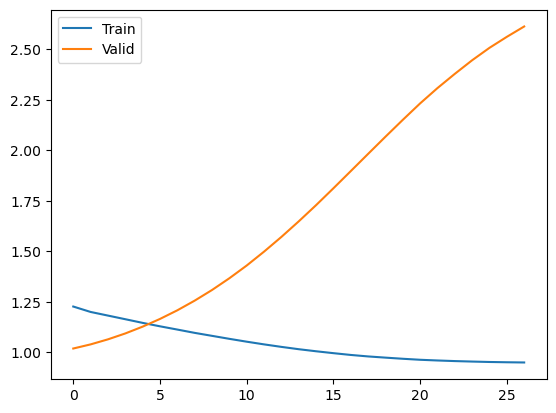

In [16]:
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Valid')
plt.legend();

In [9]:
study.best_trials[0].params

{'activation': 'SeLU',
 'distribution': 'LogNormal',
 'k': 3,
 'learning_rate': 0.003925619631692259,
 'lin1': 102,
 'lin2': 60,
 'lin3': 173,
 'lin4': 226,
 'lin5': 117}